# Visualize CNN Weights and Activations

In [1]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import skimage.filters
import keras
from keras.applications import vgg16
from keras import backend as K

# Allow graph embeding in notebook
%matplotlib inline

/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate 

## Helper Functions

In [2]:
def tensor_summary(tensor):
    """Display shape, min, and max values of a tensor."""
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

    
def normalize(image):
    """Takes a tensor of 3 dimensions (height, width, colors) and normalizes it's values
    to be between 0 and 1 so it's suitable for displaying as an image."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)


def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    """
    images: A list of images. I can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11, 11 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1


## Build VGG16 Convolutional Network

In [3]:
# Build a VGG16 Convolutional Network pre-trained on ImageNet
model = vgg16.VGG16(weights='imagenet')
model.summary()

553467904/553467096 [==============================] - 53s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_p

## Test the Model on Random Images

In [4]:
# Pick a random image from the Web.
# Make sure it's 224x224 image since VGG16 expects this size.
orig_image = skimage.io.imread("dog.jpeg")
orig_image.shape

(183, 275, 3)

In [5]:
import cv2
import os
import glob
from scipy.misc import imread, imsave
import imageio

image = cv2.resize(orig_image,(224, 224))

In [6]:
image.shape

(224, 224, 3)

shape: (224, 224, 3)  min: 0  max: 255


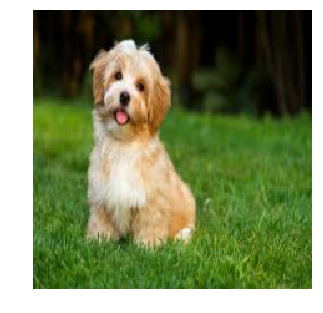

In [7]:
tensor_summary(image)
display_images([image], cols=2)

In [8]:
# Convert image to float
x = image.astype(np.float32)
# Make it a batch of one. The model expects a batch, not a single image
x = x[np.newaxis,...]
# Preprocess image. Convert RGB to BGR and subtract the ImageNet mean.
x = vgg16.preprocess_input(x)

In [9]:
# Classify the image
predictions = model.predict(x)
# We'll get a 1000 values. Print the first 10.
print(predictions[0][:10])

[1.8888454e-07 2.9941120e-07 1.3513929e-08 1.8768137e-08 1.3288951e-07
 1.5870853e-07 9.2238373e-08 4.0017490e-05 5.2147923e-05 1.0518097e-06]


In [10]:
# Find the largest confidence value. This corresponds to the label index.
label_index = np.argmax(predictions)
print("label index: ", label_index)
# Display the top 5 classes
vgg16.decode_predictions(predictions)

label index:  194
40960/35363 [==================================] - 0s 6us/step


[[('n02096437', 'Dandie_Dinmont', 0.3950122),
  ('n02097474', 'Tibetan_terrier', 0.19197547),
  ('n02098413', 'Lhasa', 0.09550766),
  ('n02094114', 'Norfolk_terrier', 0.08241909),
  ('n02091635', 'otterhound', 0.062419772)]]

In [12]:
# List of ImageNet classes. Print a subset of the 1000
# The previous call to decode_predictions() sets the value
# of CLASS_INDEX, so call that function first.
imagenet_classes = keras.applications.imagenet_utils.CLASS_INDEX
for i in range(10):
    print(i, imagenet_classes[str(i)][1])

AttributeError: module 'keras.applications' has no attribute 'imagenet_utils'

## Heatmap

In [13]:
step = 56
heatmap_x = []
for row in range(0, image.shape[0], step):
    for col in range(0, image.shape[1], step):
        new_image = image.copy()
        # Add a square patch. Using a bright color here to make it easier to see.
        new_image[row:row+step, col:col+step, :] = [250,128,128]
        heatmap_x.append(new_image)
heatmap_x = np.stack(heatmap_x)
heatmap_x.shape

(16, 224, 224, 3)

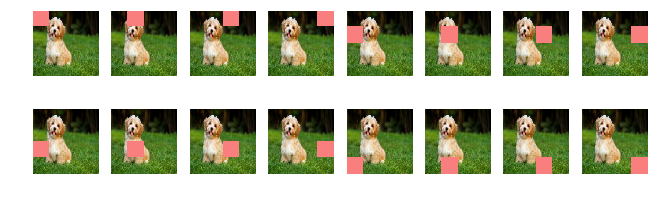

In [14]:
display_images(heatmap_x[:28], cols=8)

In [15]:
heatmap_y = model.predict(vgg16.preprocess_input(heatmap_x.astype(np.float32)))
tensor_summary(heatmap_y)

shape: (16, 1000)  min: 2.9021729464062673e-10  max: 0.603948175907135


In [16]:
probs = heatmap_y[:, label_index]
tensor_summary(probs)

shape: (16,)  min: 0.035676680505275726  max: 0.603948175907135


In [17]:
heatmap = (probs.max() - probs) / (probs.max()-probs.min())
heatmap = np.reshape(heatmap, (4, 4))
tensor_summary(heatmap)

shape: (4, 4)  min: 0.0  max: 1.0


shape: (4, 4)  min: 0.0  max: 1.0


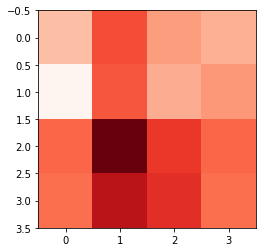

In [18]:
tensor_summary(heatmap)
_ = plt.imshow(heatmap, cmap=plt.cm.Reds)

shape: (224, 224, 3)  min: 0.0  max: 237.9916688219421


/home/sara/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


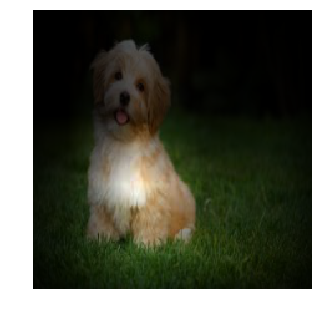

In [19]:
def apply_mask(image, mask):
    # Resize mask to match image size
    mask = skimage.transform.resize(normalize(mask), image.shape[:2])[:,:,np.newaxis].copy()
    # Apply mask to image
    image_heatmap = image * mask
    tensor_summary(image_heatmap)
    display_images([image_heatmap], cols=2)


# Apply mask to image
apply_mask(image, heatmap**2)

## Visualize the Weights

In [20]:
weights = model.get_layer("block1_conv1").get_weights()[0]
weights.shape, weights.min(), weights.max()

((3, 3, 3, 64), -0.67140007, 0.6085159)

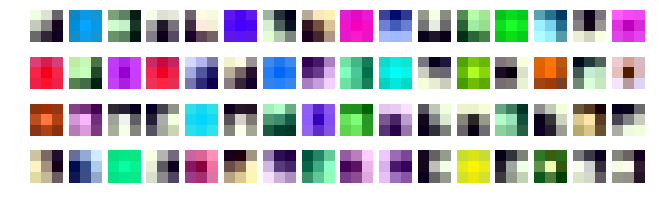

In [21]:
display_images([weights[:,:,::-1,i] for i in range(64)], cols=16, interpolation="none")

## Visualize Activations

In [22]:
def read_layer(model, x, layer_name):
    """Return the activation values for the specifid layer"""
    # Create Keras function to read the output of a specific layer
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=5):
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(10)], cols=cols)

shape: (1, 224, 224, 64)  min: 0.0  max: 531.7114868164062


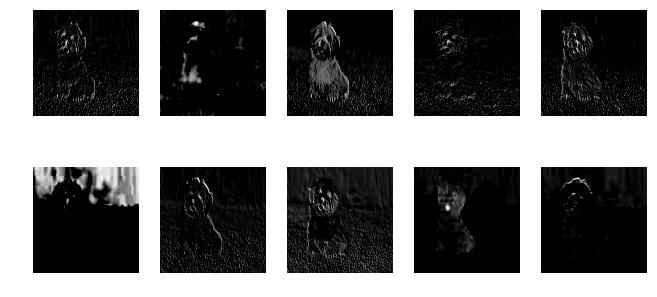

In [23]:
view_layer(model, x, "block1_conv1")

shape: (1, 224, 224, 64)  min: 0.0  max: 2331.253662109375


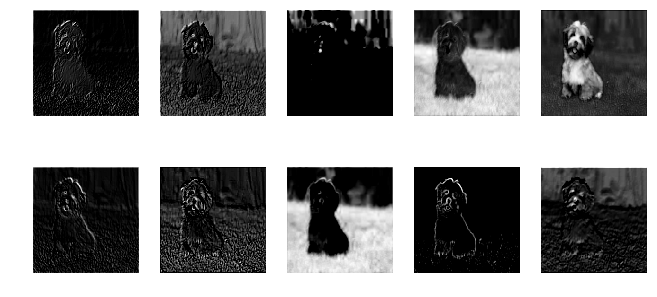

In [24]:
view_layer(model, x, "block1_conv2")

shape: (1, 112, 112, 128)  min: 0.0  max: 4527.13037109375


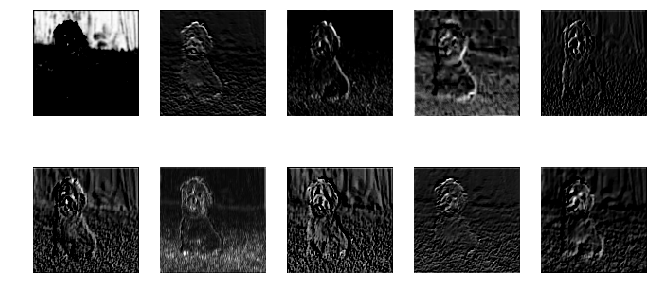

In [35]:
view_layer(model, x, "block2_conv1")

shape: (1, 56, 56, 256)  min: 0.0  max: 11013.4658203125


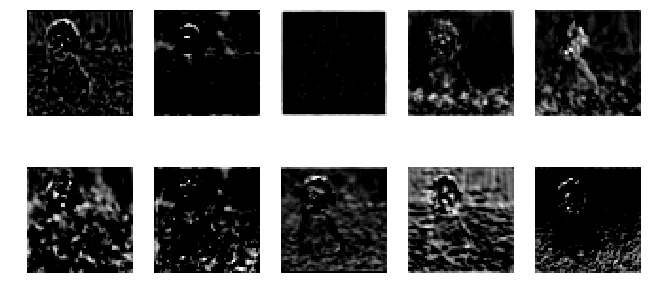

In [36]:
view_layer(model, x, "block3_conv1")

shape: (1, 28, 28, 512)  min: 0.0  max: 7250.818359375


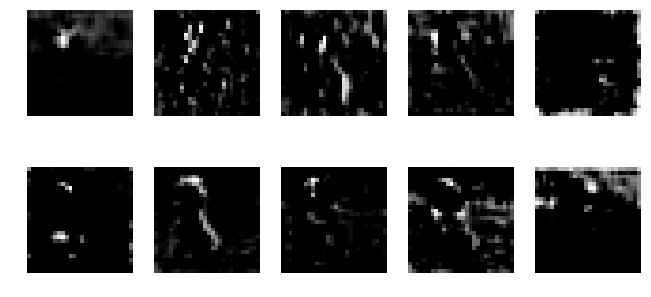

In [37]:
view_layer(model, x, "block4_conv1")

shape: (1, 14, 14, 512)  min: 0.0  max: 224.5334930419922


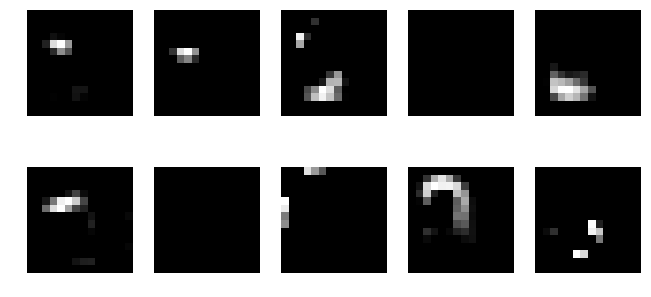

In [38]:
view_layer(model, x, "block5_conv3")

shape: (1, 14, 14, 512)  min: 0.0  max: 224.5334930419922
shape: (224, 224, 3)  min: 0.0  max: 204.2867087887427


/home/sara/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


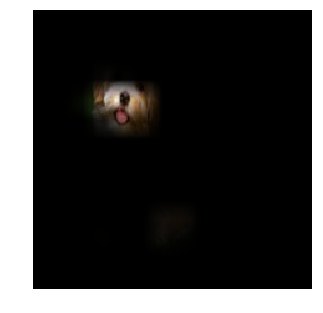

In [39]:
a = read_layer(model, x, "block5_conv3")
apply_mask(image, a[:,:,0])

shape: (1, 1000)  min: 4.797584995941406e-09  max: 0.3950121998786926


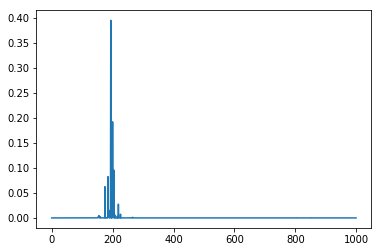

In [40]:
# The last layer is a 1D 1000-vector. Visualize as a bar chart.
a = read_layer(model, x, "predictions")
_ = plt.plot(a)

## Gradient Descent to Image Space

Or, gradient ascent, depending on which loss function you choose.

In [41]:
def build_backprop(model, loss):
    # Gradient of the input image with respect to the loss function
    gradients = K.gradients(loss, model.input)[0]
    # Normalize the gradients
    gradients /= (K.sqrt(K.mean(K.square(gradients))) + 1e-5)
    # Keras function to calculate the gradients and loss
    return K.function([model.input], [loss, gradients])

### Visualize the Gradients on the Input Image

shape: (1, 224, 224, 3)  min: -10.556666374206543  max: 9.421242713928223


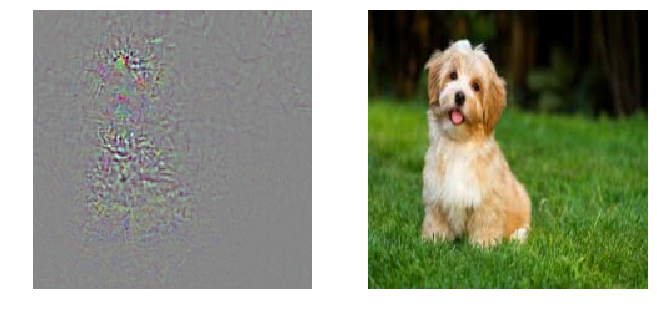

In [42]:
# Loss function that optimizes one class
loss_function = K.mean(model.get_layer("predictions").output[:,label_index])

# Backprop function
backprop = build_backprop(model, loss_function)

# Calculate gradients on the input image
loss, grads = backprop([x])
tensor_summary(grads)

# Visualize the gradients
grad_image = normalize(grads)
display_images([grad_image[0], image], cols=2)

## Generate an Image That Maximizes A Class 

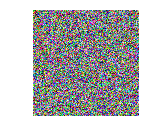

In [43]:
# Start with a random image
random_image = np.random.random((1, 224, 224, 3))
display_images(random_image)

Loss: 0.00013022301
Loss: 0.010656467
Loss: 0.18576516
Loss: 0.9037427
Loss: 0.9959812
shape: (1, 224, 224, 3)  min: -9.68526678153418  max: 8.205356396889753


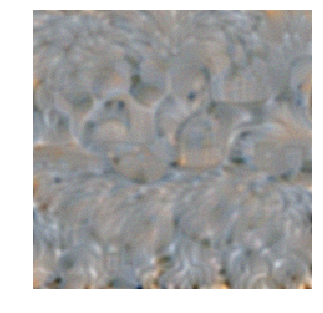

In [44]:
# Iteratively apply gradient ascent
for i in range(50):
    loss, grads = backprop([random_image])
    
    # Multiply gradients by the learning rate and add to the image
    # Optionally, apply a gaussian filter to the gradients to smooth
    # out the generated image. This gives better results.
    # The first line, which is commented out, is the native method
    # and the following line uses the filter. Try with both to
    # see the difference.
    #
    # random_image += grads * .1
    random_image += skimage.filters.gaussian(np.clip(grads, -1, 1), 2) 

    # Print loss value
    if i % 10 == 0:
        print('Loss:', loss)

tensor_summary(random_image)
display_images(random_image[...,::-1], cols=2)

In [45]:
# Classify the image
predictions = model.predict(random_image)
vgg16.decode_predictions(predictions)

[[('n02096437', 'Dandie_Dinmont', 0.997849),
  ('n02091635', 'otterhound', 0.00047914792),
  ('n02095889', 'Sealyham_terrier', 0.00029180766),
  ('n02097047', 'miniature_schnauzer', 0.00017736235),
  ('n02097209', 'standard_schnauzer', 0.00012703895)]]

## Maximize Activations for a Hidden Filter

In [46]:
# Loss function that optimizes one class
loss_function = K.mean(model.get_layer("block1_conv1").output[:,:,:,0])

# Backprop function
backprop = build_backprop(model, loss_function)

# Start with a random image
random_image = np.random.random((1, 224, 224, 3)) 

Loss: 0.75801694
Loss: 2.5285125
Loss: 5.6574306
Loss: 8.946402
Loss: 12.297161
shape: (1, 224, 224, 3)  min: -29.282690699446615  max: 30.662606732048605


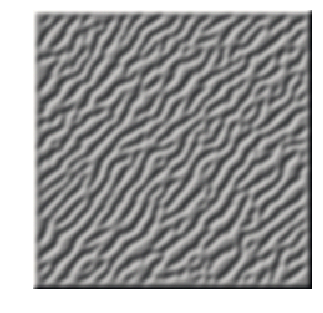

In [47]:
# Iteratively apply gradient ascent
for i in range(50):
    loss, grads = backprop([random_image])
    grads = np.nan_to_num(grads)  # In case gradients are NaN
    # Apply gradients with or without a gaussian filter
    # random_image += grads * .1
    random_image += skimage.filters.gaussian(np.clip(grads, -1, 1), 2) 
    if i % 10 == 0:
        print('Loss:', loss)

tensor_summary(random_image)
display_images(random_image[...,::-1], cols=2)

## Match Activations of Original Image

In [48]:
# Read activiations all all layers
activations = []
for layer in model.layers[1:]:
    # Extract activations
    get_layer_output = K.function([model.input], [layer.output])
    activations.append( (layer.name, get_layer_output([x])[0]) )
    tensor_summary(activations[-1][1])

shape: (1, 224, 224, 64)  min: 0.0  max: 531.7114868164062
shape: (1, 224, 224, 64)  min: 0.0  max: 2331.253662109375
shape: (1, 112, 112, 64)  min: 0.0  max: 2331.253662109375
shape: (1, 112, 112, 128)  min: 0.0  max: 4527.13037109375
shape: (1, 112, 112, 128)  min: 0.0  max: 7348.1220703125
shape: (1, 56, 56, 128)  min: 0.0  max: 7348.1220703125
shape: (1, 56, 56, 256)  min: 0.0  max: 11013.4658203125
shape: (1, 56, 56, 256)  min: 0.0  max: 8210.6796875
shape: (1, 56, 56, 256)  min: 0.0  max: 9852.931640625
shape: (1, 28, 28, 256)  min: 0.0  max: 9852.931640625
shape: (1, 28, 28, 512)  min: 0.0  max: 7250.818359375
shape: (1, 28, 28, 512)  min: 0.0  max: 4456.53173828125
shape: (1, 28, 28, 512)  min: 0.0  max: 3816.700927734375
shape: (1, 14, 14, 512)  min: 0.0  max: 3816.700927734375
shape: (1, 14, 14, 512)  min: 0.0  max: 2278.13525390625
shape: (1, 14, 14, 512)  min: 0.0  max: 1115.065185546875
shape: (1, 14, 14, 512)  min: 0.0  max: 224.5334930419922
shape: (1, 7, 7, 512)  min: 0

In [49]:
# Build the loss function
loss_function = 0
for l, a in activations:
    print(l)
    loss_function += K.mean(K.sqrt((model.get_layer(l).output - a)**2))
loss_function = -loss_function

# Backprop function
backprop = build_backprop(model, loss_function)

# Start with a random image
random_image = np.random.random((1, 224, 224, 3)) * 10

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions


Loss: -2050.4207
Loss: -2050.4207
Loss: -2050.4207
Loss: -2050.4207
Loss: -2050.4207
shape: (1, 224, 224, 3)  min: 8.173358777341377e-05  max: 9.999916999504224


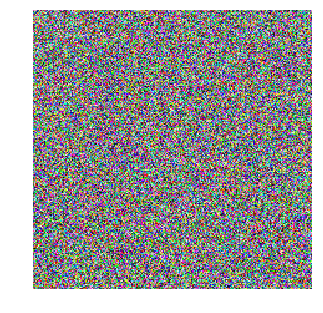

In [50]:
for i in range(50):
    loss, grads = backprop([random_image])
    grads = np.nan_to_num(grads)
    #random_image += grads * .1
    random_image += skimage.filters.gaussian(np.clip(grads, -1, 1), 2) 
    if i % 10 == 0:
        print('Loss:', loss)

tensor_summary(random_image)
display_images(random_image[...,::-1], cols=2)